### Torch Dataset

In [3]:
from PIL import Image, ImageOps
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms import Grayscale, Normalize, RandomAffine, RandomApply
import numpy as np
import pandas as pd

class LineDataset(Dataset):
    def __init__(self, image_dir, target_height=128, target_width=1024, transform=True):
        self.image_dir = image_dir
        self.target_height = target_height
        self.target_width = target_width
        self.transform = transform
        self.image_files = os.listdir(image_dir)
        self.labels = pd.read_csv('labels.csv',  encoding = "ISO-8859-1", header=None)
        self.unique_chars = set(''.join(self.labels[1].values))
        self.encode = dict()
        self.decode = dict()
        for idx,char in enumerate(self.unique_chars):
            self.encode[char] = idx + 1
            self.decode[idx + 1] = char
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path)
        if self.transform:
            image = ImageOps.grayscale(image) 
        image = self.resize_and_pad_image(image, (self.target_height, self.target_width))

        # normalize
        image = image.float()
        image = Normalize([0.5], [0.5])(image)

        # random augmentation
        affine_transform = RandomAffine(degrees=(-1, 1), shear=(-30, 30, -5, 5), scale=(0.6, 1.2), )
        apply_gauss = RandomApply(transforms=[self.gauss_noise_tensor], p=0.293)
        apply_affine = RandomApply(transforms=[affine_transform], p=0.293)
        
        image = apply_affine(image)        
        image = apply_gauss(image)

        label_idx = int(img_name.split('.jpg')[0])
        label = self.labels.loc[label_idx][1]
        label = ' ' + label + ' ' # add white space to represent padding
        label = self.tokenize(label)
        return (image, label)

    def tokenize(self, text):
        tokenized = []
        for char in text:
            tokenized.append(self.encode[char])
        return torch.tensor(tokenized)

    def decode_tokens(self, text):
        decoded = ''
        for token in text.tolist():
            decoded += self.decode[token]
        return decoded

    def gauss_noise_tensor(self, img):
        assert isinstance(img, torch.Tensor)
        dtype = img.dtype
        if not img.is_floating_point():
            img = img.to(torch.float32)
        
        sigma = 25.0
        
        out = img + sigma * torch.randn_like(img)
        
        if out.dtype != dtype:
            out = out.to(dtype)
            
        return out

    def resize_and_pad_image(self, image: Image.Image, target_size: tuple):    
        # Calculate the aspect ratio of the original image and the target size
        original_width, original_height = image.size
        target_height, target_width = target_size
    
        # Ensure target_size is valid
        assert target_height > 0 and target_width > 0, "Target size must be positive values."
    
        # Resize the image if it is larger than the target size while maintaining the aspect ratio
        if original_width > target_width or original_height > target_height:
            image = TF.resize(image, target_size, interpolation=Image.LANCZOS)
    
        # Calculate padding dimensions to maintain aspect ratio
        resized_width, resized_height = image.size
        padding_left = (target_width - resized_width) // 2
        padding_right = target_width - resized_width - padding_left
        padding_top = (target_height - resized_height) // 2
        padding_bottom = target_height - resized_height - padding_top
    
        # Calculate median value of the image (usually 0 for grayscale)
        median_value = int(np.median(np.array(image)))
        padded_image = ImageOps.expand(image, (padding_left, padding_top, padding_right, padding_bottom), fill=median_value)
    
        # Ensure the final image has the correct size
        assert padded_image.size == (target_width, target_height), "Final image does not match the target size."
    
        return TF.pil_to_tensor(padded_image)

    def collate_fn(self, batch):
        images = None
        labels = None
        
        for i,l in batch:
            if images == None:
                images = i.unsqueeze(0)
                labels = l.unsqueeze(0)
            else:
                # pad labels if needed
                if labels.shape[-1] < l.shape[-1]:
                    labels = nn.functional.pad(labels, (0, l.shape[-1] - labels.shape[-1]), "constant", -1)
                else:
                    l = nn.functional.pad(l, (0, labels.shape[-1] - l.shape[-1]), "constant", -1)

                # concat batch
                images = torch.cat([images, i.unsqueeze(0)], dim=0)
                labels = torch.cat([labels, l.unsqueeze(0)], dim=0)

        return images, labels

torch.Size([2, 1, 128, 1024]) tensor([[50, 44, 50,  2, 76, 35, 71, 50, 77,  5, 50, 66, 48, 43, 65,  6, 23, 69,
         50],
        [50, 34, 39, 43, 71, 50, 66, 39, 43, 45, 52,  5, 74, 50, -1, -1, -1, -1,
         -1]])


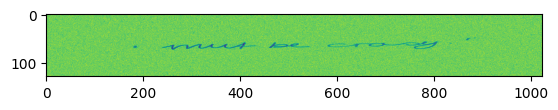

In [21]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

dataset = LineDataset(
    './gen'
)

train = DataLoader(dataset, batch_size=2, collate_fn=dataset.collate_fn, shuffle=True)
p,l = next(iter(train))

print(p.shape, l)
plt.imshow(p[0].permute(1, 2, 0))

### CNN Backbone

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class CNN(nn.Module):
    def __init__(self, cnn_cfg):
        super(CNN, self).__init__()

        self.k = 1

        self.features = nn.ModuleList([nn.Conv2d(1, 32, 7, [4, 2], 3), nn.ReLU()])
        in_channels = 32
        cntm = 0
        cnt = 1

        for m in cnn_cfg:
            if m == 'M':
                self.features.add_module('mxp' + str(cntm), nn.MaxPool2d(kernel_size=2, stride=2))
                cntm += 1
            else:
                for i in range(int(m[0])):
                    x = int(m[1])
                    self.features.add_module('cnv' + str(cnt), BasicBlock(in_channels, x,))
                    in_channels = x
                    cnt += 1

    def forward(self, x, reduce='max'):
        y = x
        for i, nn_module in enumerate(self.features):
            y = nn_module(y)

        # flattening maxpool
        y = F.max_pool2d(y, [y.size(2), self.k], stride=[y.size(2), 1], padding=[0, self.k//2])

        return y

class CTCtopB(nn.Module):
    def __init__(self, input_size, rnn_cfg, nclasses, rnn_type='gru'):
        super(CTCtopB, self).__init__()

        hidden, num_layers = rnn_cfg

        if rnn_type == 'gru':
            self.rec = nn.GRU(input_size, hidden, num_layers=num_layers, bidirectional=True, dropout=.2)
        elif rnn_type == 'lstm':
            self.rec = nn.LSTM(input_size, hidden, num_layers=num_layers, bidirectional=True, dropout=.2)
        else:
            print('problem! - no such rnn type is defined')
            exit()
        
        self.fnl = nn.Sequential(nn.Dropout(.5), nn.Linear(2 * hidden, nclasses))

        self.cnn = nn.Sequential(nn.Dropout(.5), 
                                 nn.Conv2d(input_size, nclasses, kernel_size=(1, 3), stride=1, padding=(0, 1))
        )

    def forward(self, x):
        y = x.permute(2, 3, 0, 1)[0]
        y = self.rec(y)[0]

        y = self.fnl(y)

        if self.training:
            return y, self.cnn(x).permute(2, 3, 0, 1)[0]
        else:
            return y, self.cnn(x).permute(2, 3, 0, 1)[0]


### HTR Network

In [8]:
class HTRNet(nn.Module):
    def __init__(self, arch_cfg, nclasses):
        super(HTRNet, self).__init__()
        cnn_cfg = arch_cfg['cnn_cfg']
        self.features = CNN(cnn_cfg)
        hidden = cnn_cfg[-1][-1]

        head = arch_cfg['head_type']
        if head=='cnn':
            self.top = CTCtopC(hidden, nclasses)
        elif head=='rnn':
            self.top = CTCtopR(hidden, (arch_cfg['rnn_hidden_size'], arch_cfg['rnn_layers']), nclasses, rnn_type=arch_cfg['rnn_type'])
        elif head=='both':
            self.top = CTCtopB(hidden, (arch_cfg['rnn_hidden_size'], arch_cfg['rnn_layers']), nclasses, rnn_type=arch_cfg['rnn_type'])

    def forward(self, x):
        y = self.features(x)
        y = self.top(y)

        return y

In [26]:
def load_model(model, optimizer, scheduler, path_to_model='htr_model.pth'):
    checkpoint = torch.load(path_to_model)
    
    # Load
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, scheduler, epoch

In [29]:
# DEVICE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(47173969058300)

# MODEL PARAMETERS
BATCH_SIZE = 16
epochs = 800
LR = 1e-3
SAVE_EVERY = 50

arch_cfg = dict({
    'cnn_cfg': eval("[[2, 64], 'M', [3, 128], 'M', [2, 256]]"),
    'head_type':'both',
    'rnn_hidden_size':256,
    'rnn_layers':3,
    'rnn_type':'lstm'
})


# DATASET
dataset = LineDataset('./gen')
train,test = torch.utils.data.random_split(dataset, [0.9, 0.1])
train = DataLoader(train, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)

# MODEL, OPTIMIZER, SCHEDULER
n_classes = len(dataset.unique_chars) + 1
model = HTRNet(arch_cfg, n_classes)
model.train()
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), LR, weight_decay=0.00005)
criterion = lambda y, t, ly, lt: nn.CTCLoss(reduction='sum', zero_infinity=True)(F.log_softmax(y, dim=2), t, ly, lt) / BATCH_SIZE
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(.5*epochs), int(.75*epochs)], gamma=0.1)

try:
    model, optimizer, scheduler, epoch = load_model(model, optimizer, scheduler)
    print("Loaded model en accessories succesfully!")
except:
    print("Failed Loading saved model")

for epoch in range(epoch, epochs):
    running_loss = 0
    for img,labels in train:
        # forward
        optimizer.zero_grad()
        img, labels = img.to(device), labels.to(device)
        out,aux_out = model(img)
    
        # loss
        inp_lens = torch.IntTensor(img.size(0)*[out.size(0)])
        label_lens = torch.sum(labels > 0, dim=1)
        
        # bidirectional 2 losses
        loss = criterion(out, labels, inp_lens, label_lens)
        loss += 0.1 * criterion(aux_out, labels, inp_lens, label_lens)
    
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    print(f"loss {epoch}: {running_loss / len(train)}")
    if epoch % SAVE_EVERY == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()
        }, './htr_model.pth')
        print(f"Saved checkpoints at Epoch:{epoch}")

C:\Users\Ali\AppData\Local\Temp\ipykernel_11984\609109721.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_to_model)


Loaded model en accessories succesfully!
loss 400: 138.14059448242188
Saved checkpoints at Epoch:400
loss 401: 118.18853247748481
loss 402: 114.50474446614584
loss 403: 108.84836297776964
loss 404: 101.62024959140354
loss 405: 94.56004027472602
loss 406: 87.60893360561795
loss 407: 81.1941397857666
loss 408: 76.3030660586887
loss 409: 72.39957864549424
loss 410: 69.31774687025282
loss 411: 66.85662942250569
loss 412: 64.5236570570204
loss 413: 63.03392392900255
loss 414: 61.519399350484214
loss 415: 60.121813621521
loss 416: 58.78748657226563
loss 417: 57.571411577860516
loss 418: 56.46779134114583
loss 419: 55.74531967163086
loss 420: 54.9647719446818
loss 421: 54.0180190955268
loss 422: 53.96889136844211
loss 423: 52.54909154256185
loss 424: 52.20598386976454
loss 425: 51.74813856336806
loss 426: 50.8426835208469
loss 427: 50.83898033565945
loss 428: 50.064394332038034
loss 429: 49.27455790201823
loss 430: 49.16786481645372
loss 431: 49.20371464623345
loss 432: 48.34810149722629
loss

### EVAL

In [31]:
counter = 0
test_loader = test
for test_img, test_label in test:
    test_img, test_label = test_img.to(device), test_label.to(device)
    
    model.eval()
    with torch.no_grad():
        pred, aux_pred = model(test_img.unsqueeze(0))
        pred = F.log_softmax(pred, dim=2).argmax(dim=2).squeeze()
        tt = [v for j, v in enumerate(pred) if j == 0 or v != pred[j - 1]]
        dec_transcr = ''.join([dataset.decode[t.item()] for t in tt if t != 0])
        label_transcr = ''.join([dataset.decode[t.item()] for t in test_label.squeeze()])
        print(dec_transcr)
        print(label_transcr)
        # plt.imshow(test_img.squeeze().cpu())
        counter += 1
        if counter == 10:
            break

 Tfrchimedes! 
 Archimedes! 
 Ad if.. 
 And if... 
 "He beed is Compire and fit for an eapres. 
 The bed is Empire and fit for an empress. 
 - What? -Tomorrow Iechange unifornes. 
 - What? - Tomorrow I change uniforms. 
 Oh, Miss Scarlett.... 
 Oh, Miss Scarlett.... 
 A rlaygy on me sathn, t he wot iter of a cer they wen. Dothen hnd hente thing no inho e. 
 He knew she was fooling, but he was happy. For she was near him, holding his hand, smiling at him. 
 - We're not gonno miss a thing! 
 - We're not gonna miss a thing! 
 That I et ear. 
 That is very clear. 
 Aod this in whiss heyu. 
 And this is Miss Ferguson. 
 I'm sure we can. 
 I'm sure we can. 
